In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
from pathlib import Path
proj_path = Path('.').resolve()
sys.path.append(str(proj_path))

import matplotlib.pyplot as plt
import seaborn as sns

import json
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from typing import Optional
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_core.runnables import RunnableSequence
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate

_ = load_dotenv(find_dotenv())

from src.db_utils import get_schema_str, get_data_dict
from src.pymodels import (
    DatabaseModel, 
    SpiderSample, 
    BirdSample, 
    BODescription,
    SQLResponse
)
from src.prompts import Prompts
from src.database import SqliteDatabase
from src.data_preprocess import (
    load_raw_data,
    process_all_tables,
    filter_samples_by_count_spider_bird,
    process_samples_bird,
    split_train_dev_test,
    save_samples_spider_bird,
    load_samples_spider_bird,
)

from src.parsing_sql import Schema, extract_all
from src.eval_utils import get_complexity, result_eq, check_if_exists_orderby
from run_bo_sql import get_vector_store
from copy import deepcopy

from src.eval_utils import get_structural_score, get_all_structural_score, get_all_semantic_score, partial_matching_with_penalty
from run_evaluation import get_target_parsed_sql, get_prediction_parsed_sql
from run_bo_sql import _get_categories, _format_interval, get_retriever
from bert_score import score as bscore
from transformers import logging as tfloggings
tfloggings.set_verbosity_error()
import warnings

In [3]:
# from langchain.globals import set_llm_cache
# from langchain_community.cache import SQLiteCache
# set_llm_cache(SQLiteCache(database_path=f"./cache/valid_bo_bird_dev.db"))

In [612]:
file_name = 'soccer_2016-0'
db = SqliteDatabase(f"./cache/valid_bo_{file_name}.db")
db.start()
c = db.con.cursor()
c.execute('BEGIN TRANSACTION')
c.execute("""
DELETE FROM full_llm_cache WHERE response LIKE '%JSONDecodeError%';
""")
# c.execute('''
# DELETE FROM full_llm_cache
# WHERE prompt LIKE '%Which teams have had a player awarded the Purple Cap and another with the Orange Cap%'
# ''')
db.con.commit()
db.close()
# JSONDecodeError
# ValidationError

In [611]:
from pprint import pprint
df = db.execute(
'''
SELECT * FROM full_llm_cache
WHERE prompt LIKE '%Which teams have had a player awarded the Purple Cap and another with the Orange Cap%'
''')
df

,prompt,llm,idx,response


---

In [3]:
from src.eval_utils import get_structural_score, get_all_structural_score, get_all_semantic_score, partial_matching_with_penalty
from run_evaluation import get_target_parsed_sql, get_prediction_parsed_sql
from run_bo_sql import _get_categories, _format_interval, get_retriever
from bert_score import score as bscore
from transformers import logging as tfloggings
tfloggings.set_verbosity_error()
import warnings

ds = 'spider'
task = 'zero_shot_hint'
typ = 'test'
scenario = 0
description_file = f'description.json' if ds == 'spider' else f'{ds}_description.json'
experiment_folder = proj_path / 'experiments' / ds
prediction_path = experiment_folder / 'predictions' / task
eval_path = experiment_folder / 'evals' / task

tables, *_ = load_raw_data(proj_path / 'data' / ds, load_test=False)
with (proj_path / 'data' / description_file).open() as f:
    all_descriptions = json.load(f)
tables = process_all_tables(tables, descriptions=all_descriptions)

In [ ]:
# bird_path = proj_path / 'data' / 'bird'
# tables, train_data, dev_data = load_raw_data(bird_path, load_test=False)

# with (proj_path / 'data' / 'bird_description.json').open() as f:
#     all_descriptions = json.load(f)

# bird_tables = process_all_tables(tables, descriptions=all_descriptions)
# train_samples = load_samples_spider_bird(proj_path / 'data' / 'bird_train.json')
# dev_samples = load_samples_spider_bird(proj_path / 'data' / 'bird_dev.json')
# test_samples = load_samples_spider_bird(proj_path / 'data' / 'bird_test.json')

In [6]:
# file_post_fix = f'{ds}_{typ}' if scenario < 0 else f'{ds}_{typ}_{scenario}'
# final_file = f'final_{file_post_fix}.json'
# samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_{typ}.json')

# if not (prediction_path / final_file).exists():
#     all_results = []
#     paths = sorted(list(prediction_path.glob(f'{file_post_fix}_*.json')))
#     for p in paths:
#         with p.open() as f:
#             results = json.load(f)
            
#         for r in results:
#             r.pop('rationale')
#             r['db_id'] = p.stem.split('_', 3)[-1]

#             found = False
#             for s in samples:
#                 if r['sample_id'] == s.sample_id:
#                     found = True
#                     break
#             r['gold_sql'] = s.final.sql
#             assert found, r['sample_id']

#         all_results.extend(results)

In [7]:
# with open(prediction_path / final_file, 'r') as f:
#     preds = json.load(f)

In [ ]:
# pred_parsed, _ = get_prediction_parsed_sql(preds, tables)

wta_1: 100%|██████████| 1508/1508 [00:02<00:00, 548.94it/s]                         


# Training a retrieval model

In [5]:
ds = 'bird'
typ = 'dev'
task = 'retrieval' # 'zero_shot', 'retrieval', 'valid_bo'
description_file = f'description.json' if ds == 'spider' else f'{ds}_description.json'
experiment_folder = proj_path / 'experiments' / ds

eval_path = experiment_folder / 'evals' / task
prediction_path = experiment_folder / 'predictions' / task

tables, *_ = load_raw_data(proj_path / 'data' / ds, load_test=False)
with (proj_path / 'data' / description_file).open() as f:
    all_descriptions = json.load(f)
tables = process_all_tables(tables, descriptions=all_descriptions)

In [5]:
# with open(experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json', 'r') as f:
#     train_bo = json.load(f)

# df = []
# for db_id, xs in train_bo.items():
#     for x in xs:
#         x['db_id'] = db_id
#         df.append(x)

# df = pd.DataFrame(df)
# cates = pd.qcut(df['gold_complexity'], q=5)
# df['gold_complexity_cates'] = cates
# df['gold_complexity_codes'] = cates.cat.codes
# df.to_csv(experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.csv', index=False)
# df = pd.read_csv(experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.csv')

# df_train = df.groupby('gold_complexity_codes').sample(frac=0.9, random_state=42)
# df_dev = df.drop(df_train.index)

# print(df_train['gold_complexity_codes'].value_counts().sort_index())
# print(df_dev['gold_complexity_codes'].value_counts().sort_index())

# df_train.to_csv(experiment_folder / 'predictions' / 'create_bo' / f'{ds}_{task}_trainset.csv', index=False)
# df_dev.to_csv(experiment_folder / 'predictions' / 'create_bo' / f'{ds}_{task}_devset.csv', index=False)

create hard negative sample pools

In [5]:
with open(experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json', 'r') as f:
    train_bo = json.load(f)
# create dataframe
df = []
for db_id, xs in train_bo.items():
    for x in xs:
        x['db_id'] = db_id
        df.append(x)

df = pd.DataFrame(df)
cates = pd.qcut(df['gold_complexity'], q=5)
df['gold_complexity_cates'] = cates
df['gold_complexity_codes'] = cates.cat.codes

In [4]:
with open(experiment_folder / 'predictions' / 'create_bo' / f'data_retrieval_rerank.json', 'r') as f:
    data = json.load(f)

In [193]:
from sentence_transformers import (
    SentenceTransformer, 
    SentenceTransformerTrainer, 
    SentenceTransformerTrainingArguments, 
    losses,
    CrossEncoder,
    InputExample
)
from datasets import Dataset
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator, RerankingEvaluator, InformationRetrievalEvaluator
from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator
from torch.utils.data import DataLoader
import random 
from itertools import product
import uuid

class BADataset():
    def __init__(
            self, 
            data: dict[str, dict[str, str|dict[str, int]]],
            bert_scores: dict[str, float],
            task: str, 
            n_neg: int=1,
            threshold: float=0.1,
        ):
        """
        samples: dict[str, dict[int|str, str]] = {
            'question': {sample_id: question, ...},
            'ba': {sample_id: ba, ...},
            'gold_complexity_codes': {sample_id: gold_complexity_codes, ...}
        }
        bert_scores: dict[str, float] = {
            'sample_id1-sample_id2': score, ...  # intra-db sample pairs
        }

        # task: retrieval
        Instead of using MultipleNegativesRankingLoss we use TripletLoss, since most samples are similar. 
        So we need to design triplets that negative samples are from 
        1. same databases: harder to train (avoid ba is too similar to positive with certain threshold)
        2. different databases: easier to train

        construct: (anchor, positive, negative) 
        - anchor: question
        - positive: ba
        - negative: ba (`n_neg` from same database and `n_neg` from different database)
        sample number: `n_neg` (same database) + `n_neg` (different database)
        
        # task: rerank
        We train a binary classifier to predict whether the question and ba are relevant (share the complexity code) or not.
        If we do random sampling, it will be too easy for the model to predict the label.
        So we need sample negative samples from:
        1. same database: harder to train
        2. different database: easier to train

        construct: (text, label)
        - text: question, ba
        - label: gold_complexity_codes
        sample number: 5 (1 positive, `n_neg` negative)
        - positive: 1 query, ba (target code, db_id)
        - `n_neg` negative: from same db, different code to the target code (if impossible for a certain code, try to replace with other codes)
        - `n_neg` negative: from different db, different code to the target code
        """
        self.task = task
        self.bert_scores: dict[str, float] = bert_scores
        # if threshold < 0 and task == 'retrieval':
        #     self.use_adaptive_threshold = True
        #     self.stats: dict[str, float] = self._check_stats_bert_score()['raw']
        # else:
        #     self.use_adaptive_threshold = False
        self.threshold = threshold
    
        self.n_neg = n_neg
        self._reorganize_samples(data)
        # self.samples = self.create_samples_by_task()

    def save_samples(self, sample_save_path):
        with open(sample_save_path, 'w') as f:
            json.dump(self.samples, f)

    def load_samples(self, sample_save_path):
        with open(sample_save_path, 'r') as f:
            self.samples = json.load(f)

    def _reorganize_samples(self, samples: dict[str, dict[int|str, str]]):
        # sid == sample_id, qid is from 0 to len(samples['question'])
        # [sid1, sid2, ...] -- index of this list is qid
        self.sample_ids = list(samples['question'].keys())
        
        # question: {qid: question}
        # ba: {sid: ba}
        # db_id: {qid: db_id}
        # db_id2qids: {db_id: [qid1, qid2, ...]}
        # codes: {qid: gold_complexity_codes}
        # codes2qids: {db_id: {gold_complexity_codes: [qid1, qid2, ...]}}
        self.questions = {}
        self.bas = {}
        self.db_ids = {}
        self.db_id2qids: dict[str, list[int]] = defaultdict(list)
        self.codes = {}
        self.codes2qids: dict[str, dict[int, list[int]]] = defaultdict(dict)

        for qid, sid in enumerate(self.sample_ids):
            self.questions[qid] = samples['question'][sid]
            self.bas[sid] = samples['ba'][sid]
            
            db_id = samples['db_id'][sid]
            self.db_ids[qid] = db_id
            self.db_id2qids[db_id].append(qid)

            code = samples['gold_complexity_codes'][sid]
            self.codes[qid] = code
            if code not in self.codes2qids[db_id]:
                self.codes2qids[db_id][code] = []
            self.codes2qids[db_id][code].append(qid)

        self.n_unique_codes = len(set(self.codes.values()))

    def _check_stats_bert_score(self):
        dist = defaultdict(list)
        unique_keys = defaultdict(set)
        for key in self.bert_scores:
            k1, k2 = key.split('-')
            unique_keys[k1].add(k2)
            unique_keys[k2].add(k1)

        for key, cand_keys in unique_keys.items():
            scores = [] 
            for cand_key in cand_keys:
                search_key = f'{key}-{cand_key}' if f'{key}-{cand_key}' in self.bert_scores else f'{cand_key}-{key}'
                scores.append(self.bert_scores[search_key])

            dist[key] = np.mean(scores)

        x = list(dist.values())
        
        return {
            'mean': np.mean(x), 'std': np.std(x), 'min': np.min(x), 'max': np.max(x), 'raw': x
        }

    def create_samples_by_task(self):
        """
        question: {qid: question}
        ba: {cid: ba}
        db_id: {qid: db_id}
        db_id2qids: {db_id: [qid1, qid2, ...]}
        codes: {qid: gold_complexity_codes}
        codes2qids: {db_id: {gold_complexity_codes: [qid1, qid2, ...]}}
        """
        if self.task == 'retrieval':
            # create triplets: (anchor, positive, negative)
            # sample number: n_neg (same database) + n_neg (different database)
            self.samples = self._retrieval_sample_generation()
        elif self.task == 'rerank':
            # create pairs: (text=[question, ba], label)
            # sample number: <=11 (3 positive, 8 negative)
            # - 1 query, ba (target code, db_id)
            # - 1 positive: from same db, same code to the target code
            # - 1 positive: from different db, same code to the target code
            # - 4 (at least) negative: from same db, different code to the target code
            # - 4 negative: from different db, different code to the target code
            self.samples = self._rerank_sample_generation()
        else:  # task not found
            raise ValueError(f'Invalid task: {self.task}')

    def _retrieval_sample_generation(self):
        samples = []
        distributions = defaultdict(lambda: {'same_db': 0, 'diff_db': 0})  # check how many hard samples are generated(hard samples = neg from same db)
        iterator = tqdm(enumerate(self.sample_ids), total=len(self.sample_ids))
        for qid, sid in iterator:
            s: dict[str, int|str|list[int]] = {
                'anchor': qid,
                'positive': sid,
                'negative': []  # [neg_sid1, neg_sid2, ...]
            }
            db_id = self.db_ids[qid]

            # negative samples in same database
            iterator.set_postfix_str(f'[{self.task}-{qid}] sampling neg sample from same database')
            i = 0
            sampled = set()  # {qid}
            neg_qids_same_db = []
            n_neg_same_db = self.n_neg
            n_neg_diff_db = self.n_neg
            while i < n_neg_same_db:
                candidates = np.setdiff1d(self.db_id2qids[db_id], [qid]+list(sampled))
                if len(candidates) == 0:
                    # no existing samples that are in the same db, need to sample from different db
                    # warnings.warn(f'[{db_id}-{sid}] No more samples, will sample from different database')
                    n_neg_diff_db += 1
                    i += 1
                    continue
                
                # check sampled ba is too similar to positive ba
                keys: list[tuple[int, str]] = []
                for cqid in candidates:
                    csid = self.sample_ids[cqid]
                    if f'{sid}-{csid}' in self.bert_scores:
                        keys.append((cqid, f'{sid}-{csid}'))
                    elif f'{csid}-{sid}' in self.bert_scores:
                        keys.append((cqid, f'{csid}-{sid}'))
                    else:
                        raise KeyError(f'[{db_id}-{sid}] No bert score found for {sid}-{csid} or {csid}-{sid}')
                # filter too similar samples that over threshold
                candidates = [cqid for (cqid, key) in keys if self.bert_scores[key] < self.threshold]
                if len(candidates) == 0:
                    # warnings.warn(f'[{db_id}-{sid}] No more samples to be sampled that match criteria, it will sample from different database')
                    n_neg_diff_db += 1
                    i += 1
                    continue
                
                sampled_qid = np.random.choice(candidates)

                # check if sampled_qid not in sampled
                if sampled_qid not in sampled:
                    neg_qids_same_db.append(sampled_qid)
                    sampled.add(sampled_qid)
                    i += 1
                    distributions[qid]['same_db'] += 1

            neg_sids_same_db = [self.sample_ids[neg_qid] for neg_qid in neg_qids_same_db]
            s['negative'].extend(neg_sids_same_db)

            # negative samples in different database
            iterator.set_postfix_str(f'[{self.task}-{qid}] sampling neg sample from different database')
            i = 0
            sampled = set()  # {qid}
            neg_qids_diff_db = []
            while i < n_neg_diff_db:
                db_ids_candidates = np.setdiff1d(list(self.db_id2qids.keys()), [db_id])
                sampled_db_id = np.random.choice(db_ids_candidates)
                candidates = np.setdiff1d(self.db_id2qids[sampled_db_id], list(sampled))
                sampled_qid = np.random.choice(candidates)

                # don't need to check sampled ba is too similar to positive ba for different db
                # check if sampled_qid not in sampled
                if sampled_qid not in sampled:
                    neg_qids_diff_db.append(sampled_qid)
                    sampled.add(sampled_qid)
                    i += 1
                    distributions[qid]['diff_db'] += 1

            neg_sids_diff_db = [self.sample_ids[neg_qid] for neg_qid in neg_qids_diff_db]
            s['negative'].extend(neg_sids_diff_db)

            for neg_sid in s['negative']:
                samples.append({
                    'anchor': int(s['anchor']),
                    'positive': s['positive'],
                    'negative': neg_sid
                })

        self._distributions = distributions
        return samples

    def _rerank_sample_generation(self):
        samples = []
        iterator = tqdm(enumerate(self.sample_ids), total=len(self.sample_ids))
        
        # same db, diff code = sd
        # diff db, diff code = dd
        # since it will run for all samples, positive samples are fixed
        # so we need to sample negative samples
        def verifier():
            pass

        def sum_sampled(db_sampled):
            return sum([len(qids) for qids in db_sampled.values()])

        for qid, sid in iterator:
            s: dict[str, list[list[str]]|list[int]] = {
                'text': [],
                'label': []
            }
            # target
            target_code = self.codes[qid]
            db_id = self.db_ids[qid]
            s['text'].append([qid, sid])
            s['label'].append(1)

            # negative from same db, different code: sd
            iterator.set_postfix_str(f'[{self.task}-{qid}] sampling neg sample from same database')
            i = 0
            n_neg_dd = self.n_neg
            n_neg_ds = self.n_neg
            same_db_sampled = set()  # {qid}
            while i < n_neg_ds:
                # check enough qids to sample for other codes
                # code_candidate should have at least 1 sample that is not in sampled before
                sd_code_candidates = []
                for code, qids in self.codes2qids[db_id].items():
                    if (code != target_code) and \
                        (len(np.setdiff1d(qids, list(same_db_sampled))) > 0):
                        sd_code_candidates.append(code)
                if len(sd_code_candidates) == 0:
                    # means that there is no more samples in db_id, keep sampling from other dbs
                    n_neg_dd += 1
                    i += 1
                    continue
                    
                sd_code = np.random.choice(sd_code_candidates)
                sd_qid_candidates = np.setdiff1d(self.codes2qids[db_id][sd_code], 
                                                 [qid]+list(same_db_sampled))
                sd_qid = np.random.choice(sd_qid_candidates)
                sd_sid = self.sample_ids[sd_qid]
                
                # check if sd_qid not in sampled
                if sd_qid not in same_db_sampled:
                    s['text'].append([qid, sd_sid])
                    s['label'].append(0)
                    same_db_sampled.add(sd_qid)
                    i += 1

            # negative from different db, different code
            iterator.set_postfix_str(f'[{self.task}-{qid}] sampling neg sample from different database')
            i = 0
            diff_db_sampled = defaultdict(set)  # {db_id: {qid}}
            dd_sampled_db_ids = set()  # {db_id} only added if there is no samples that have the same code in different db
            while i < n_neg_dd:
                dd_db_ids_candidates = np.setdiff1d(list(self.db_id2qids.keys()), 
                                                    [db_id]+list(dd_sampled_db_ids))
                dd_sampled_db_id = np.random.choice(dd_db_ids_candidates)

                # check enough qids to sample for other codes
                # code_candidate should have at least 1 sample that is not in sampled before
                dd_code_candidates = []
                for code, qids in self.codes2qids[dd_sampled_db_id].items():
                    if (code != target_code) and \
                        (len(np.setdiff1d(qids, list(diff_db_sampled[dd_sampled_db_id]))) > 0):
                        dd_code_candidates.append(code)
                if len(dd_code_candidates) == 0:
                    # means that there is no more samples in sampled_db_id, keep sampling from other dbs
                    dd_sampled_db_ids.add(dd_sampled_db_id)
                    continue

                dd_code = np.random.choice(dd_code_candidates)
                dd_qid_candidates = np.setdiff1d(self.codes2qids[dd_sampled_db_id][dd_code], 
                                                 list(diff_db_sampled[dd_sampled_db_id]))
                dd_qid = np.random.choice(dd_qid_candidates)
                dd_sid = self.sample_ids[dd_qid]

                # check if sampled_qid not in sampled
                if dd_qid not in diff_db_sampled[dd_sampled_db_id]:
                    s['text'].append([qid, dd_sid])
                    s['label'].append(0)
                    diff_db_sampled[dd_sampled_db_id].add(dd_qid)
                    i += 1

            for i in range(len(s['text'])):
                samples.append({
                    'text': [int(s['text'][i][0]), s['text'][i][1]], # [qid, sid]
                    'label': s['label'][i]
                })

        return samples


    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        if self.task == 'retrieval':
            return self._retrieval_task_itemgetter(idx)
        elif self.task == 'rerank':
            return self._rerank_task_itemgetter(idx)
        else:
            raise ValueError(f'Invalid task: {self.task}')
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def _retrieval_task_itemgetter(self, idx):
        # {anchor: qid, positive: sid, negative: sid}
        sample = self.samples[idx]
        qid = sample['anchor']
        pos_id = sample['positive']
        neg_id = sample['negative']
        
        question = self.questions[qid]
        pos_ba = self.bas[pos_id]
        neg_ba = self.bas[neg_id]

        return {
            'anchor': question,
            'positive': pos_ba,
            'negative': neg_ba
        }
    
    def _rerank_task_itemgetter(self, idx):
        # `sentence_transfomer` will update there code th newer version later. 
        # Here, we use old version for training cross-encoder
        # {text: [question, ba], label: label}
        sample = self.samples[idx]
        qid, sid = sample['text']
        label = sample['label']

        question = self.questions[qid]
        ba = self.bas[sid]
        return {
            'text': [question, ba],
            'label': label
        }
    
    def get_rerank_samples(self, is_train: bool=True):
        samples = []
        if is_train:
            for x in self:
                samples.append(InputExample(texts=x['text'], label=x['label']))
        else:
            # {qid: {'positive': [sid1, sid2, ...], 'negative': [sid1, sid2, ...]}}
            sample_ids = defaultdict(lambda : {'positive': [], 'negative': []})
            for s in self.samples:
                qid, sid = s['text']
                label = s['label']
                if label == 1:
                    sample_ids[qid]['positive'].append(sid)
                else:
                    sample_ids[qid]['negative'].append(sid)

            for qid, v in sample_ids.items():
                samples.append({
                    'query': self.questions[qid],
                    'positive': [self.bas[sid] for sid in v['positive']],
                    'negative': [self.bas[sid] for sid in v['negative']]
                })
        return samples

In [194]:
train_dataset = BADataset(
    data=data['train'],
    bert_scores=data['bert_scores'], 
    task='retrieval', 
    n_neg=2,
    threshold=0.25,
)
x = train_dataset._check_stats_bert_score()
x['mean'], x['std'], x['min'], x['max']

(0.3612745325582957,
 0.06275672978943266,
 0.1056786763171355,
 0.5432230182762804)

In [181]:
train_dataset = BADataset(
    data=data['train'],
    bert_scores=data['bert_scores'], 
    task='retrieval', 
    n_neg=2,
    threshold=0.3,
)
train_dataset.create_samples_by_task()
train_save_path = experiment_folder / 'predictions' / 'create_bo' / f'retrieval_train.json'
train_dataset.save_samples(sample_save_path=train_save_path)

dev_dataset = BADataset(
    data=data['dev'],
    bert_scores=data['bert_scores'], 
    task='retrieval', 
    n_neg=1,
    threshold=0.3,
)
dev_dataset.create_samples_by_task()
dev_save_path = experiment_folder / 'predictions' / 'create_bo' / f'retrieval_dev.json'
dev_dataset.save_samples(sample_save_path=dev_save_path)

print(f'train: {len(train_dataset)}, dev: {len(dev_dataset)}')

100%|██████████| 633/633 [00:00<00:00, 672.73it/s, [retrieval-632] sampling neg sample from different database]


train: 22832, dev: 1266


<Axes: xlabel='diff_db', ylabel='count'>

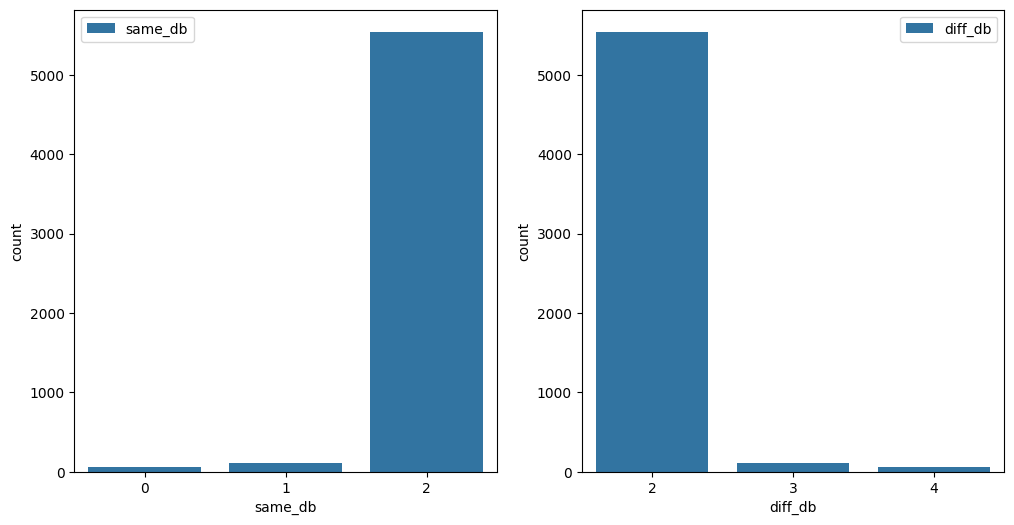

In [ ]:
df = pd.DataFrame(train_dataset._distributions).T
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df, x='same_db', ax=axes[0], label='same_db')
sns.countplot(data=df, x='diff_db', ax=axes[1], label='diff_db')

In [195]:
train_dataset = BADataset(
    data=data['train'],
    bert_scores=data['bert_scores'], 
    task='rerank',
    n_neg=4,
)
train_dataset.create_samples_by_task()
train_save_path = experiment_folder / 'predictions' / 'create_bo' / f'rerank_train.json'
train_dataset.save_samples(sample_save_path=train_save_path)

dev_dataset = BADataset(
    data=data['dev'],
    bert_scores=data['bert_scores'], 
    task='rerank', 
    n_neg=4,
)
dev_dataset.create_samples_by_task()
dev_save_path = experiment_folder / 'predictions' / 'create_bo' / f'rerank_dev.json'
dev_dataset.save_samples(sample_save_path=dev_save_path)

print(f'train: {len(train_dataset)}, dev: {len(dev_dataset)}')

100%|██████████| 633/633 [00:01<00:00, 382.33it/s, [rerank-632] sampling neg sample from different database]


train: 51372, dev: 5697


---

In [199]:
train_dataset = BADataset(
    data=data['train'],
    bert_scores=data['bert_scores'], 
    task='retrieval', 
    n_neg=2,
    threshold=0.3,
)
train_dataset.load_samples(experiment_folder / 'predictions' / 'create_bo' / f'retrieval_train.json')

dev_dataset = BADataset(
    data=data['dev'],
    bert_scores=data['bert_scores'], 
    task='retrieval', 
    n_neg=1,
    threshold=0.3,
)
dev_dataset.load_samples(experiment_folder / 'predictions' / 'create_bo' / f'retrieval_dev.json')

In [198]:
base_model_name = 'msmarco-MiniLM-L6-cos-v5'
model = SentenceTransformer(base_model_name)

In [ ]:
train_ds = Dataset.from_generator(train_dataset.__iter__)
dev_ds = Dataset.from_generator(dev_dataset.__iter__)

exp_name = f'{base_model_name.split("/")[-1]}-q_ba'

args = SentenceTransformerTrainingArguments(
    output_dir=f'models/{exp_name}',
    num_train_epochs=1,
    learning_rate=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    logging_steps=1,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="steps",
    eval_steps=1,
    torch_empty_cache_steps=100,
    save_strategy="steps",
    save_steps=1,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir=f'logs/{exp_name}',
)

loss = losses.MultipleNegativesRankingLoss(model)

dev_evaluator = TripletEvaluator(
    anchors=dev_ds['anchor'],
    positives =dev_ds['positive'],
    negatives=dev_ds['negative'],
    name='q_ba_dev',
)

trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_ds,
    loss=loss,
    args=args,
    eval_dataset=dev_ds,
    evaluator=dev_evaluator,
)

trainer.train()

---

In [201]:
train_dataset = BADataset(
    data=data['train'],
    bert_scores=data['bert_scores'], 
    task='rerank',
    n_neg=4,
)
train_dataset.load_samples(experiment_folder / 'predictions' / 'create_bo' / f'rerank_train.json')
dev_dataset = BADataset(
    data=data['dev'],
    bert_scores=data['bert_scores'], 
    task='rerank', 
    n_neg=4,
)
dev_dataset.load_samples(experiment_folder / 'predictions' / 'create_bo' / f'rerank_dev.json')

In [202]:
base_model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
model = CrossEncoder(base_model_name, num_labels=1)

In [211]:
train_samples = train_dataset.get_rerank_samples(is_train=True)
train_loader = DataLoader(
    train_samples, batch_size=256, shuffle=True, num_workers=0)
dev_samples = dev_dataset.get_rerank_samples(is_train=False)
# dev_loader = DataLoader(
#     dev_samples, batch_size=16, shuffle=False, num_workers=0)

rank_evaluator = CERerankingEvaluator(dev_samples, name="train-eval")

In [ ]:
warmup_steps = 5000

# Train the model
model.fit(
    train_dataloader=train_loader,
    evaluator=rank_evaluator,
    epochs=1,
    evaluation_steps=20,
    warmup_steps=warmup_steps,
    output_path='temp',
    use_amp=False,
)

In [205]:
for x in dev_dataset.samples:
    if x['text'][0] == 0:
        print(x)

{'text': [0, '6081'], 'label': 1}
{'text': [0, '6006'], 'label': 0}
{'text': [0, '5993'], 'label': 0}
{'text': [0, '5939'], 'label': 0}
{'text': [0, '6086'], 'label': 0}
{'text': [0, '255'], 'label': 0}
{'text': [0, '10633'], 'label': 0}
{'text': [0, '745'], 'label': 0}
{'text': [0, '8543'], 'label': 0}


In [ ]:
args = SentenceTransformerTrainingArguments(
    output_dir=f'models/temp',
    num_train_epochs=1,
    learning_rate=0.001,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_ratio=0.1,
    logging_steps=1,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="steps",
    eval_steps=1,
    load_best_model_at_end=True,
)
loss = losses.MarginMSELoss(model)
dev_samples = dev_dataset.create_rerank_eval_set()
dev_evaluator = RerankingEvaluator(dev_samples, at_k=3, name="train-eval")

trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_ds,
    loss=loss,
    args=args,
    eval_dataset=dev_ds,
    evaluator=dev_evaluator,
)

trainer.train()

In [140]:
train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=0)
dev_loader = DataLoader(
    dev_ds, batch_size=2, shuffle=False, num_workers=0)

In [ ]:
eval_samples = dev_dataset.create_rerank_eval_set()

In [ ]:
# dev_samples = {'query': '', 'positive': [], 'negative': []}
eval_samples = dev_dataset.create_rerank_eval_set()
# evaluator = CERerankingEvaluator(dev_samples[-10:], at_k=10, name="train-eval")
evaluator = CEBinaryClassificationEvaluator(
    sentence_pairs=[x['text'] for x in dev_dataset],
    labels=[x['label'] for x in dev_dataset]
)
res = evaluator(model)

# model2 = SentenceTransformer(base_model_name)
# evaluator2 = RerankingEvaluator(dev_samples, at_k=10, name="train-eval")
# evaluator2(model2)

No sentence-transformers model found with name cross-encoder/ms-marco-MiniLM-L-6-v2. Creating a new one with mean pooling.


{'train-eval_map': 0.16666666666666666,
 'train-eval_mrr@10': 0.16666666666666666,
 'train-eval_ndcg@10': 0.35620718710802235}

In [31]:
dev_dataset.samples['question'].keys()

dict_keys([6081, 5993, 6086, 6017, 6056, 6006, 6108, 6109, 6030, 5971, 6005, 5939, 5934, 6034, 2559, 2554, 2522, 2556, 727, 715, 699, 7275, 7250, 7335, 7269, 7246, 7446, 7253, 7340, 7223, 7359, 7310, 7047, 7150, 7262, 7379, 7171, 7099, 7377, 301, 255, 309, 328, 265, 345, 389, 362, 392, 245, 288, 22, 144, 140, 10, 73, 4641, 4654, 4653, 4720, 4644, 4695, 4723, 4660, 5306, 5293, 5337, 5290, 5353, 5357, 5333, 5315, 5227, 5144, 5175, 5110, 5197, 5149, 5095, 5210, 5121, 5097, 2007, 2011, 2033, 1974, 2014, 2019, 1843, 1911, 1803, 1963, 1932, 1937, 1919, 1879, 2035, 982, 1007, 2494, 1122, 1086, 1148, 1058, 1191, 1108, 1062, 1163, 1167, 1207, 1157, 1059, 1116, 6411, 6508, 6316, 3675, 3584, 3660, 3607, 3663, 3649, 3522, 3602, 3578, 3564, 3528, 2698, 2615, 2600, 2631, 2635, 2722, 2652, 2705, 2660, 4889, 4844, 4749, 4780, 4856, 4786, 4872, 4887, 4790, 4767, 4802, 4806, 4783, 10767, 10881, 10775, 10809, 10772, 10792, 10739, 10707, 10584, 10633, 10704, 10710, 10587, 10663, 10572, 10685, 10682, 10691

In [32]:
dev_dataset.samples.keys()

dict_keys(['question', 'ba', 'gold_complexity_codes'])

In [ ]:
ir_evaluator = InformationRetrievalEvaluator(
    dev_queries,
    corpus,
    dev_rel_docs,
    show_progress_bar=True,
    corpus_chunk_size=100000,
    precision_recall_at_k=[10, 100],
    name="msmarco dev",
)

1.0

In [ ]:
model.fit(
    train_dataloader=train_loader,
    evaluator=evaluator,
    epochs=1,
    evaluation_steps=1,
    warmup_steps=1,
    use_amp=False,
)

TypeError: FitMixin.fit() got an unexpected keyword argument 'train_dataloader'

In [132]:
dev_samples = [{
    'query': 'What is the capital of France?',
    'positive': ['Pariss'],
    'negative': ['London', 'Berlin', 'Madrid']
}]

# evaluator = CERerankingEvaluator(dev_samples, at_k=3, name="train-eval")
evaluator = RerankingEvaluator(dev_samples, at_k=10, name="train-eval")
evaluator(model)

{'train-eval_map': 0.5,
 'train-eval_mrr@10': 0.5,
 'train-eval_ndcg@10': 0.6309297535714573}

# Procedures

## task: valid_bo

1. (retrieve) retrieve and rerank for dev dataset to get relevant train BOs
2. (gen_template) generate sql template with dev dataset and retrieved BOs --> output: dev sql templates
3. (fill_in) fill-in values with dev sql templates --> output: dev sql
4. (evaluate) evaluate the dev sql to get the most helpful train BOs --> output: BOs Pool

## task: inference_with_bo

1. (retrieve) retrieve and rerank for test dataset from BOs Pool
2. (gen_template) generate sql template with test dataset and retrieved BOs --> output: test sql templates
3. (fill_in) fill-in values with test sql templates --> output: test sql
4. (evaluate) evaluate the test sql


### retrieve

In [21]:
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.retrievers import BaseRetriever
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_core.embeddings import Embeddings

In [95]:
file_name = 'retrieval_dev.json'
prediction_path = experiment_folder / 'predictions' / 'retrieve'
with open(prediction_path / file_name, 'w') as file:
    all_results = []
    for p in prediction_path.glob(f'x-*.json'):
        with p.open() as f:
            temp = json.load(f)
        all_results.extend(temp)
    json.dump(all_results, file, indent=4)

In [96]:
for p in prediction_path.glob(f'x-*.json'):
    p.unlink()

In [83]:
def get_vector_store(
        bos: dict[str, list[dict[str, str]]], 
        embeddings_model: Embeddings,
        is_question_query: bool=False
    ) -> FAISS:
    documents = []
    for db_id, samples in bos.items():
        for x in samples:
            doc = Document(
                page_content=x['ba'] if not is_question_query else x['question'],
                metadata={
                    'sample_id': x['sample_id'],
                    'db_id': db_id,
                    'vt': x['vt'],
                    'complexity': x['gold_complexity']
                }
            )
            documents.append(doc)

    vector_store = FAISS.from_documents(
        documents, 
        embedding = embeddings_model,
    )
    return vector_store

def get_retriever(
        vectorstore: FAISS,
        db_id: str='',
        cross_encoder: HuggingFaceCrossEncoder=None,
        n_retrieval: int=3,
        k_retrieval: int=10,
        score_threshold: float=0.60,
        use_reranker: bool= False,
    ) -> BaseRetriever:
    k_retrieval = k_retrieval if use_reranker else n_retrieval
    base_retriever = vectorstore.as_retriever(
        search_type='similarity_score_threshold', # 'similarity',
        search_kwargs={
            'k': k_retrieval, 
            'score_threshold': score_threshold, 
            'filter': {'db_id': db_id},
        }
    )
    if use_reranker:
        compressor = CrossEncoderReranker(model=cross_encoder, top_n=n_retrieval)
        retriever = ContextualCompressionRetriever(
            base_compressor=compressor, base_retriever=base_retriever
        )
    else:
        retriever = base_retriever
    return retriever

embedding_model = 'custom'
reranker_model = 'custom'
if embedding_model == 'openai':
        embeddings_model = OpenAIEmbeddings()
elif embedding_model == 'custom':
    embeddings_model = HuggingFaceEmbeddings(model_name='./models/msmarco-MiniLM-L6-cos-v5-q_ba')

if reranker_model == 'msmarco':
    cross_encoder = HuggingFaceCrossEncoder(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2')
elif reranker_model == 'custom':
    cross_encoder = HuggingFaceCrossEncoder(model_name='./models/ms-marco-MiniLM-L-6-v2-q_ba-rerank')

bo_path = experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
with bo_path.open() as f:
    bos = json.load(f)

# remove duplicate bos
hash_map = defaultdict(set)
for db_id, xs in bos.items():
    for x in xs:
        hash_map[x['vt']].add(x['sample_id'])

ids = list(map(lambda x: list(x)[0], hash_map.values()))
new_bos = {}
for db_id, xs in bos.items():
    new_bos[db_id] = [x for x in xs if x['sample_id'] in ids]

bos = new_bos

In [84]:
typ = 'dev'
samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_{typ}.json')
# df = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_dev.csv')
# df_error = df.loc[df['exec_result'] == 0]
# error_ids = df_error['sample_id'].tolist()
# samples = list(filter(lambda x: x.sample_id in error_ids, samples))
samples_by_db_id = defaultdict(list)
for sample in samples:
    samples_by_db_id[sample.db_id].append(sample)

for i, (db_id, ss) in enumerate(samples_by_db_id.items()):
    print(f'[{db_id}] {len(ss)}')
    if i == 5:
        print('...')
        break

db_id = list(bos.keys())[0]
x_samples = list(filter(lambda x: x.db_id == db_id, samples))

[movie_platform] 33
[book_publishing_company] 14
[retail_complains] 33
[movies_4] 31
[codebase_comments] 24
[trains] 8
...


In [85]:
vector_store = get_vector_store(
    bos, embeddings_model=embeddings_model, is_question_query=False)
retriever = get_retriever(
    vectorstore=vector_store,
    db_id=db_id,
    cross_encoder=cross_encoder,
    n_retrieval=3,
    k_retrieval=10,
    score_threshold=0.50,
    use_reranker=True,
)

In [86]:
question = x_samples[0].final.question
print(question)

Give the author's name of the books that cost 19 dollars and above.


In [87]:
x_samples[0].final.sql

'SELECT DISTINCT T3.author_name FROM book AS T1 INNER JOIN book_author AS T2 ON T1.book_id = T2.book_id INNER JOIN author AS T3 ON T3.author_id = T2.author_id INNER JOIN order_line AS T4 ON T4.book_id = T1.book_id WHERE T4.price > 19'

In [88]:
retriever.invoke(question)

No relevant docs were retrieved using the relevance score threshold 0.5


[]

[movie_platform] 33
[book_publishing_company] 14
[retail_complains] 33
[movies_4] 31
[codebase_comments] 24
[trains] 8
...


In [13]:
df_cates = df_base.groupby('db_id')['gold_complexity'].apply(_get_categories).rename('category').apply(_format_interval)
df_base = pd.merge(df_base, df_cates.reset_index('db_id', drop=True), left_index=True, right_index=True)

df = pd.merge(
    left=df_bo,
    right=df_base,
    how='inner',
    on=['db_id', 'sample_id', 'gold_complexity'],
    suffixes=('_bo', '_base')
)

In [14]:
group_column = ['db_id', 'retrieved']
execution_improvement = df.groupby(group_column)[['exec_result_base', 'exec_result_bo']].sum().diff(axis=1)['exec_result_bo'].rename('execution_improvement')
merit_structural = df.groupby(group_column)[['structural_score_base', 'structural_score_bo']].mean().diff(axis=1)['structural_score_bo'].rename('merit_structural')
merit_semantic = df.groupby(group_column)[['semantic_score_base', 'semantic_score_bo']].mean().diff(axis=1)['semantic_score_bo'].rename('merit_semantic')
merit = df.groupby(group_column)[['f1_score_base', 'f1_score_bo']].mean().diff(axis=1)['f1_score_bo'].rename('merit')

ranks = merit.reset_index().groupby(['db_id'])['merit'].rank(method='first', ascending=False).rename('rank').astype(np.int64)
merit = pd.concat([merit.reset_index(), ranks], axis=1)
merit_by_rank = merit.sort_values(by=['db_id', 'rank'], ascending=True)

# merit.head()

In [15]:
(merit_by_rank.groupby('db_id')['merit'].mean().sort_values(ascending=False) > 0.0).value_counts()

merit
True     85
False    41
Name: count, dtype: int64

In [12]:
test_bos = defaultdict(list)
for x in merit_by_rank.loc[:, ['db_id', 'retrieved']].to_dict(orient='records'):
    test_bos[x['db_id']].append(x['retrieved'])

n_bos = range(5, 26, 5)
test_scenarios = defaultdict(dict)
for n_bo in n_bos:
    for db_id in test_bos:
        test_scenarios[n_bo][db_id] = test_bos[db_id][:n_bo]

In [13]:
with (experiment_folder / 'test_scenarios.json').open('w') as f:
    json.dump(test_scenarios, f)

In [21]:
from src.parsing_sql import Schema, extract_all

sql1 = """SELECT * FROM lineitem"""

schema = Schema({
    'lineitem': {'l_receiptdate': 'date', 'l_commitdate': 'date'}
})

output = extract_all(sql1, schema)

In [23]:
get_complexity(output)

4

In [3]:
# spider_path = proj_path / 'data' / 'spider'
# tables, train_data, dev_data = load_raw_data(spider_path, load_test=False)

# with (proj_path / 'data' / 'description.json').open() as f:
#     all_descriptions = json.load(f)
# seed = 42
# all_data = filter_samples_by_count_spider_bird(train_data+dev_data, n=10)

# with open(proj_path / 'data' / 'bird_skip.txt') as f:
#     skip = [int(line.strip()) for line in f]

# bird_samples = process_samples_bird(all_data, bird_tables, skip=skip)
# train_samples, dev_samples, test_samples = split_train_dev_test(bird_samples, train_ratio=0.6, dev_ratio=0.2, seed=seed)

# save_samples_spider_bird(train_samples, proj_path / 'data' / 'bird_train.json')
# save_samples_spider_bird(dev_samples, proj_path / 'data' / 'bird_dev.json')
# save_samples_spider_bird(test_samples, proj_path / 'data' / 'bird_test.json')
# print(len(train_samples), len(dev_samples), len(test_samples))

In [4]:
# experiment_folder = proj_path / 'experiments' / 'bird'
# prediction_path = experiment_folder / 'predictions' / 'create_bo'
# tables = bird_tables
# bos = []
# for p in prediction_path.glob('bird_train_bo_*.json'):
#     with p.open() as f:
#         bos = json.load(f)

#     db_id = p.stem.split('_', 3)[-1]
#     schema = Schema(tables[db_id].db_schema)
#     for bo in bos:
#         output = extract_all(bo['gold_sql'], schema)
#         bo['gold_complexity'] = get_complexity(output)
    
#     with p.open('w') as f:
#         json.dump(bos, f, indent=4)

# bos = {}
# for p in prediction_path.glob('bird_train_bo_*.json'):
#     db_id = p.stem.split('_', 3)[-1]
#     with p.open() as f:
#         bos[db_id] = json.load(f)

# with (experiment_folder / 'predictions' / 'create_bo' / f'final_bird_train_bo.json').open('w') as f:
#     json.dump(bos, f, indent=4)

In [14]:
from run_bo_sql import Sampler, get_vector_store, get_retriever
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
k_retrieval: int = 5  # for test
n_retrieval: int = 1   # for test
score_threshold: float = 0.65
use_reranker: bool = True
# TODO: run spider 4567
ds = 'bird'
task = 'zero_shot'
experiment_folder = proj_path / 'experiments' / ds
prediction_path = experiment_folder / 'predictions' / task
eval_path = experiment_folder / 'evals' / task

bo_path = experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
with bo_path.open() as f:
    bos = json.load(f)

samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_dev.json')
df = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'bird_dev.csv')
df_score = df.loc[:, ['sample_id', 'db_id', 'exec_result']]
df_error = df_score.loc[df_score['exec_result'] == 0, ['db_id', 'sample_id']]
error_ids = df_error['sample_id'].tolist()
samples = list(filter(lambda x: x.sample_id in error_ids, samples))


samples_by_db_id = defaultdict(list)
for sample in samples:
    samples_by_db_id[sample.db_id].append(sample)

cross_encoder = HuggingFaceCrossEncoder(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2')

vectorstore = get_vector_store(bos)
# dev_samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_dev.json')
# pred_res = defaultdict(dict)  # db_id -> train_bo -> list[dict]
# for p in prediction_path.glob(f'{ds}_dev_*.json'):
#     name = p.stem.split('_', 2)[-1]
#     db_id, idx = name.split('-')
#     with p.open() as f:
# 
#     for r in res:
#         train_bo_id = r['retrieved']
#         if not pred_res[db_id].get(train_bo_id):
#             pred_res[db_id][train_bo_id] = []
#         pred_res[db_id][r['retrieved']].append(r)
#     break

# save_path = prediction_path / f'final_{ds}_dev.jsonl'

In [15]:
sample_ids = []

for db_id, samples in samples_by_db_id.items():
    retriever = vectorstore.as_retriever(
        search_type='similarity_score_threshold',
        search_kwargs={
            'k': k_retrieval, 
            'score_threshold': score_threshold, 
            'filter': {'db_id': db_id, 'sample_id': {'$nin' : sample_ids}},
        }
    )
    break

In [16]:
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7ff2c8db3e90>, search_type='similarity_score_threshold', search_kwargs={'k': 5, 'score_threshold': 0.65, 'filter': {'db_id': 'movie_platform', 'sample_id': {'$nin': []}}})

In [11]:
df = pd.read_csv(eval_path / f'bird_dev.csv')
df_score = df.loc[:, ['sample_id', 'db_id', 'exec_result']]
df_score['exec_result'].sum() / len(df_score)

0.3385365853658537

In [91]:
from itertools import product
n_sample = 3
n_stop = 50
typ = 'dev'
samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_{typ}.json')
df = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_dev.csv')
df_score = df.loc[:, ['sample_id', 'db_id', 'exec_result']]
df_error = df_score.loc[df_score['exec_result'] == 0, ['db_id', 'sample_id']]
error_ids = df_error['sample_id'].tolist()
samples = list(filter(lambda x: x.sample_id in error_ids, samples))

with open(experiment_folder / f'partial_{ds}_db_ids.json') as f:
    partial_db_ids = json.load(f)

bo_path = experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
assert bo_path.exists(), 'Run with the `task=create_bo, type=train` first'
with bo_path.open() as f:
    bos = json.load(f)

# with open(experiment_folder / f'partial_{ds}_db_ids.json', 'w') as f:
#     json.dump(partial_db_ids, f, indent=4)

sampler = Sampler(bos)

sampled_bos = {}
for db_id_group in partial_db_ids:
    sampled_bos[str(db_id_group)] = defaultdict()
    for db_id in partial_db_ids[str(db_id_group)]:
        x_samples = list(filter(lambda x: x.db_id == db_id, samples))
        for idx_bos, train_bos in enumerate(sampler.sample(db_id, n_sample, n_stop, rt_idx=False)):
            # print(f'{db_id}-{idx_bos} :', f'{len(train_bos)}', f'{len(list(product(train_bos, x_samples)))}')
            sampled_bos[str(db_id_group)][f'{db_id}-{idx_bos}'] = {
                'train_bos': train_bos,
                'n_iter': len(list(product(train_bos, x_samples))), 
                'total_bos_in_batch': len(train_bos),
                'total_samples_in_batch': len(x_samples)
            }

In [5]:
ds = 'bird'
task = 'zero_shot'
experiment_folder = proj_path / 'experiments' / ds
prediction_path = experiment_folder / 'predictions' / task
eval_path = experiment_folder / 'evals' / task
typ = 'dev'
samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_{typ}.json')
df = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_dev.csv')
df_error = df.loc[df['exec_result'] == 0]
error_ids = df_error['sample_id'].tolist()
samples = list(filter(lambda x: x.sample_id in error_ids, samples))

with (experiment_folder / f'partial_{ds}_batch.json').open('r') as f:
    partial_batch = json.load(f)

In [8]:
count_files = 0
for db_group_id, batch in partial_batch.items():
    count_files += len(batch)
count_files

194

In [172]:
new_partial_batch = defaultdict()
to_be = 30
for db_id_group, batches in partial_batch.items():
    new_batch = defaultdict(dict)
    db_id_count = defaultdict(int)
    for file_name, batch in batches.items():
        db_id, idx = file_name.split('-')
        x_samples = list(filter(lambda x: x.db_id == db_id, samples))
        if db_id_count[db_id] >= to_be:
            # print('drop ', file_name)
            continue

        if db_id_count[db_id] + len(batch['train_bos']) < to_be:
            train_bos = batch['train_bos']
            new_batch[file_name] = {
                'train_bos': train_bos,
                'n_iter': len(list(product(train_bos, x_samples))),
                'total_bos_in_batch': len(train_bos),
                'total_samples_in_batch': len(x_samples)
            }
            db_id_count[db_id] += len(train_bos)
        else: # count + len(batch['train_bos']) > to_be:
            n = to_be - db_id_count[db_id]
            train_bos = batch['train_bos'][:n]
            new_batch[file_name] = {
                'train_bos': train_bos,
                'n_iter': len(list(product(train_bos, x_samples))),
                'total_bos_in_batch': len(train_bos),
                'total_samples_in_batch': len(x_samples)
            }
            db_id_count[db_id] += len(train_bos)
    
    new_partial_batch[db_id_group] = new_batch
    
    print(f'[{db_id_group}] before: file = {len(batches)} bos=' , sum([len(v['train_bos']) for v in batches.values()]), 'n_iter=', sum([v['n_iter'] for v in batches.values()]))
    print(f'[{db_id_group}] after: file = {len(new_batch)} bos=' , sum([len(v['train_bos']) for v in new_batch.values()]), 'n_iter=', sum([v['n_iter'] for v in new_batch.values()]))
    print(f'[{db_id_group}] count = {db_id_count}')
# with (experiment_folder / f'partial_{ds}_batch.json').open('w') as f:
#     json.dump(new_partial_batch, f, indent=4)

[0] before: file = 82 bos= 644 n_iter= 8394
[0] after: file = 59 bos= 511 n_iter= 1957
[1] before: file = 50 bos= 411 n_iter= 4583
[1] after: file = 45 bos= 367 n_iter= 881
[2] before: file = 62 bos= 517 n_iter= 6707
[2] after: file = 46 bos= 396 n_iter= 1184
[3] before: file = 75 bos= 690 n_iter= 10838
[3] after: file = 52 bos= 505 n_iter= 1900
[4] before: file = 68 bos= 561 n_iter= 6246
[4] after: file = 53 bos= 470 n_iter= 1264
[5] before: file = 64 bos= 508 n_iter= 6218
[5] after: file = 50 bos= 409 n_iter= 1073
[6] before: file = 70 bos= 573 n_iter= 7298
[6] after: file = 52 bos= 436 n_iter= 1577
[7] before: file = 70 bos= 583 n_iter= 8072
[7] after: file = 50 bos= 434 n_iter= 1442


In [113]:
with (experiment_folder / f'partial_{ds}_batch-back.json').open('r') as f:
    partial_batch = json.load(f)

In [191]:
# 돌려 놓은거 처리
ds = 'bird'
task = 'valid_bo'
experiment_folder = proj_path / 'experiments' / ds
prediction_path = experiment_folder / 'predictions' / task
eval_path = experiment_folder / 'evals' / task

with (experiment_folder / f'partial_{ds}_batch.json').open('r') as f:
    new_partial_batch = json.load(f)

df = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_dev.csv')
df_error = df.loc[df['exec_result'] == 0]
error_ids = df_error['sample_id'].tolist()
count_db_ids = defaultdict(int)
for p in sorted(prediction_path.glob(f'{ds}_dev_*.json')):
    name = p.stem.split('_', 2)[-1]
    db_id, idx = name.split('-')
    # if name == 'app_store-2':
    #     break
    with p.open() as f:
        res = json.load(f)
    found = False
    for db_id_group, batches in new_partial_batch.items():
        if name in batches:
            found = True
            train_bo_ids = [x['sample_id'] for x in batches[name]['train_bos']]
            break

    if not found:
        n_retrieved = set([x['retrieved'] for x in res])
        p.unlink()
        print(f'{name} not found: {len(n_retrieved)}, delete')
    else:
        n_retrieved = set([x['retrieved'] for x in res])
        count_db_ids[name] += len(n_retrieved)
        print(f'{name} before: n_retrieved = {len(n_retrieved)} | bos = {len(train_bo_ids)} | {len(res)}', end=' ')
        # error_ids 에 있는것만 남기기
        res = list(filter(lambda x: x['sample_id'] in error_ids, res))
        print(f' --> {len(res)}')
        # train_bo_ids 에 해당하는 bos만 남기기
        if len(res) < len(list(filter(lambda x: x['retrieved'] in train_bo_ids, res))):
            print(f'{name} before reduce bo: {len(res)}')
            res = list(filter(lambda x: x['retrieved'] in train_bo_ids, res))
            print(f'{name} after reduce bo: {len(res)}')

        with p.open('w') as f:
            json.dump(res, f, indent=4)

    # print()

app_store-0 before: n_retrieved = 12 | bos = 12 | 132  --> 60
app_store-1 before: n_retrieved = 12 | bos = 12 | 132  --> 60
app_store-2 before: n_retrieved = 6 | bos = 6 | 66  --> 30
app_store-3 not found: 3, delete
app_store-4 not found: 1, delete
authors-0 before: n_retrieved = 15 | bos = 15 | 510  --> 255
authors-1 before: n_retrieved = 15 | bos = 15 | 510  --> 255
authors-2 not found: 15, delete
authors-3 not found: 5, delete
books-0 before: n_retrieved = 15 | bos = 15 | 585  --> 180
books-1 before: n_retrieved = 15 | bos = 15 | 585  --> 180
books-2 not found: 15, delete
books-3 not found: 5, delete
california_schools-0 before: n_retrieved = 15 | bos = 15 | 255  --> 225
california_schools-1 before: n_retrieved = 15 | bos = 15 | 255  --> 225
california_schools-2 not found: 13, delete
california_schools-3 not found: 6, delete
california_schools-4 not found: 1, delete
college_completion-0 before: n_retrieved = 15 | bos = 15 | 225  --> 225
college_completion-1 before: n_retrieved = 15 

In [171]:
db_ids = list(bos.keys())
partial_db_ids = {}
n = 20
for i in range(30):
    if db_ids[i*n:(i+1)*n]:
        partial_db_ids[i] = db_ids[i*n:(i+1)*n]
print(partial_db_ids.keys())

with open(experiment_folder / f'partial_{ds}_db_ids.json', 'w') as f:
    json.dump(partial_db_ids, f, indent=4)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])


In [172]:
with open(experiment_folder / f'partial_{ds}_db_ids.json') as f:
    partial_db_ids = json.load(f)

sampler = Sampler(bos)

In [174]:
from itertools import product, islice

def batched(iterable, n, *, strict=False):
    # batched('ABCDEFG', 3) → ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    iterator = iter(iterable)
    while batch := tuple(islice(iterator, n)):
        if strict and len(batch) != n:
            raise ValueError('batched(): incomplete batch')
        yield batch

sampled_ids = {}
for db_id_group in partial_db_ids:
    sampled_ids[str(db_id_group)] = defaultdict()
    for db_id in partial_db_ids[str(db_id_group)]:
        x_samples = list(filter(lambda x: x.db_id == db_id, dev_samples))
        for idx_bos, train_bos in enumerate(sampler.sample(db_id, 3, 50, rt_idx=False)):
            # print(f'{db_id}-{idx_bos} :', f'{len(train_bos)}', f'{len(list(product(train_bos, x_samples)))}')
            sampled_ids[str(db_id_group)][f'{db_id}-{idx_bos}'] = {
                'train_bos': train_bos,
                'n_iter': len(list(product(train_bos, x_samples))), 
                'total_bos_in_batch': len(train_bos)
            }

with (experiment_folder / f'partial_{ds}_batch.json').open('w') as f:
    json.dump(sampled_ids, f, indent=4)

In [175]:
for db_id_group in partial_db_ids:
    print(len(sampled_ids[str(db_id_group)]))
    niters = [x['n_iter'] for x in sampled_ids[str(db_id_group)].values()]
    print(f'n_iter: {sum(niters)}, iter per file: {np.mean(niters):.2f}')

82
n_iter: 8394, iter per file: 102.37
50
n_iter: 4583, iter per file: 91.66
62
n_iter: 6707, iter per file: 108.18
75
n_iter: 10838, iter per file: 144.51
68
n_iter: 6246, iter per file: 91.85
64
n_iter: 6218, iter per file: 97.16
70
n_iter: 7298, iter per file: 104.26
70
n_iter: 8072, iter per file: 115.31


In [6]:
df = []
for db_id, bs in bos.items():
    for b in bs:
        res = {'db_id': db_id, 'gold_complexity': b['gold_complexity']}
        df.append(res)

df = pd.DataFrame(df)

In [115]:
from itertools import pairwise

def _format_interval(x: pd.Interval):
    return pd.Interval(
        left=int(np.floor(x.left)), 
        right=int(np.floor(x.right)),
        closed=x.closed
    )

def _get_categories(s: pd.Series):
    tiles = [0, 0.2, 0.4, 0.6, 0.8, 1]
    df = pd.qcut(s, q=tiles, duplicates='drop')
    return df

def _get_df_from_bos(bos):
    df = []
    for db_id, bs in bos.items():
        for b in bs:
            res = {'db_id': db_id}
            res.update(b)
            df.append(res)
    df = pd.DataFrame(df)
    df_cates = df.groupby('db_id')['gold_complexity'].apply(_get_categories)
    df_cates = df_cates.rename('category').apply(_format_interval)
    df = df.merge(df_cates.reset_index('db_id', drop=True), left_index=True, right_index=True)
    return df

In [ ]:
ds = 'bird'
task = 'zero_shot_hint'
typ = 'dev'
experiment_folder = proj_path / 'experiments' / ds
prediction_path = experiment_folder / 'predictions' / task
eval_path = experiment_folder / 'evals' / task

# file_name = f'{ds}_{typ}_parsed.pkl'
# with (eval_path / file_name).open('rb') as f:
#     target_parsed = pickle.load(f)

In [308]:
prediction_path.parent.parent

PosixPath('/home/simonjisu/code/BusinessObjects/experiments/bird')

In [304]:
bos['address'][:4]

[{'sample_id': 5156,
  'vt': "SELECT area_code.area_code, country.county FROM area_code INNER JOIN country AS T2 ON T1.zip_code = T2.zip_code INNER JOIN zip_data AS T3 ON T1.zip_code = T3.zip_code WHERE zip_data.city = '[placeholder-type:string]'",
  'ba': "The virtual table provides the area code and county information for a specific city based on its zip code. It combines data from the 'area_code', 'country', and 'zip_data' tables, filtering results to match the specified city name.",
  'gold_complexity': 10,
  'gold_sql': "SELECT T1.area_code, T2.county FROM area_code AS T1 INNER JOIN country AS T2 ON T1.zip_code = T2.zip_code INNER JOIN zip_data AS T3 ON T1.zip_code = T3.zip_code WHERE T3.city = 'Savoy'"},
 {'sample_id': 5211,
  'vt': 'SELECT alias.alias FROM alias INNER JOIN zip_data AS T2 ON T1.zip_code = T2.zip_code WHERE zip_data.population_2020 = (SELECT MAX(zip_data.population_2020) FROM zip_data)',
  'ba': "The virtual table retrieves the aliases of cities from the 'alias' t

In [4]:
from pydantic import BaseModel
from langchain_openai import ChatOpenAI

from langchain_community.callbacks.manager import get_openai_callback

class Out(BaseModel):
    response: str

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    stream_usage=True,
)
model = llm.with_structured_output(Out)


with get_openai_callback() as cb:
    result = model.invoke("Tell me a joke with JSON format")
    print(cb)

Tokens Used: 85
	Prompt Tokens: 51
	Completion Tokens: 34
Successful Requests: 1
Total Cost (USD): $2.805e-05


In [63]:
samples_by_db_id = defaultdict(list)
for sample in train_samples:
    samples_by_db_id[sample.db_id].append(sample)

x = []
for db_id, samples in samples_by_db_id.items():
    x.append(len(samples))

print(np.mean(x), np.std(x), np.min(x), np.max(x))

80.26582278481013 46.229123611557306 11 280


In [64]:
samples_by_db_id = defaultdict(list)
for sample in dev_samples:
    samples_by_db_id[sample.db_id].append(sample)

x = []
for db_id, samples in samples_by_db_id.items():
    x.append(len(samples))

print(np.mean(x), np.std(x), np.min(x), np.max(x))

26.468354430379748 15.462355628942769 3 93


In [119]:
# with open(proj_path / 'data' / 'pkl_files' / 'bird_train_parsed.pkl', 'rb') as f:
#     train_parsed = pickle.load(f)

# # prediction parsed
# with open(proj_path / 'data' / 'pkl_files' / 'bird_dev_parsed.pkl', 'rb') as f:
#     dev_parsed = pickle.load(f)

In [17]:
eval_path = proj_path / 'experiments' / 'bird' / 'evals' / 'zero_shot'

df = []
for p in eval_path.glob('bird_dev_*.json'):
    with p.open() as f:
        for line in f:
            eval_data = json.loads(line)
            df.append(eval_data)

df = pd.DataFrame(df)
df.to_csv(eval_path / 'bird_dev.csv', index=False)

In [16]:
df['gold_complexity'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.450361
std       0.055482
min       0.318118
max       0.726155
median    0.446118
Name: gold_complexity, dtype: float64

In [31]:
prediction_path = proj_path / 'experiments' / 'bird' / 'predictions' / 'create_bo'
bos = defaultdict(list)
for p in prediction_path.glob('bird_train_bo_*.json'):
    with p.open() as f:
        temp = json.load(f)
    
    bos[p.stem.split('_', 3)[-1]] = temp

# with (prediction_path / 'final_bird_train_bo.json').open('w') as f:
#     json.dump(bos, f, indent=4)

In [178]:
vector_store = get_vector_store({'address': bos['address'][:10]})

In [179]:
[b['sample_id'] for b in bos['address'][:10]]

[5156, 5211, 5227, 5091, 5152, 5128, 5200, 5119, 5194, 5141]

In [161]:
bos['address'][:10][0]

{'sample_id': 5156,
 'vt': "SELECT area_code.area_code, country.county FROM area_code INNER JOIN country AS T2 ON T1.zip_code = T2.zip_code INNER JOIN zip_data AS T3 ON T1.zip_code = T3.zip_code WHERE zip_data.city = '[placeholder-type:string]'",
 'ba': "The virtual table provides the area code and county information for a specific city based on its zip code. It combines data from the 'area_code', 'country', and 'zip_data' tables, filtering results to match the specified city name."}

In [180]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
base_retriever = vector_store.as_retriever(
    search_type='similarity_score_threshold', 
    search_kwargs={
        'k': 3,
        'score_threshold': 0.3, 'filter': {'sample_id': {'$nin': []}}
    }
)

# 'lambda_mult': 0.5  'score_threshold': 0.0
# 'filter': {'sample_id': {'$in': [5156]}}}
model = HuggingFaceCrossEncoder(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2')
compressor = CrossEncoderReranker(model=model, top_n=1)
retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=base_retriever
)

In [181]:
q = 'what is the aliases of cities along with their elevation?'
x = base_retriever.invoke(q)
x

No relevant docs were retrieved using the relevance score threshold 0.3


[]

In [182]:
x = vector_store.similarity_search_with_relevance_scores(
    q, k=2, filter={'sample_id': {'$nin': [5152, 5211, 5194]}})
x
# similarity_search_with_relevance_scores

[]

In [148]:
docs_and_similarities = [
    (doc, similarity)
    for doc, similarity in x
    if similarity >= 0.5
]
docs_and_similarities

[(Document(metadata={'sample_id': 5152, 'db_id': 'address', 'vt': 'SELECT alias.alias, zip_data.elevation FROM alias INNER JOIN zip_data AS T2 ON T1.zip_code = T2.zip_code WHERE alias.zip_code = [placeholder-type:numeric]'}, page_content="The virtual table describes the aliases of cities along with their elevation from the 'zip_data' table. The query joins the 'alias' table with the 'zip_data' table based on the zip code, filtering for a specific zip code using a placeholder for numeric values."),
  0.7825041385389271),
 (Document(metadata={'sample_id': 5211, 'db_id': 'address', 'vt': 'SELECT alias.alias FROM alias INNER JOIN zip_data AS T2 ON T1.zip_code = T2.zip_code WHERE zip_data.population_2020 = (SELECT MAX(zip_data.population_2020) FROM zip_data)'}, page_content="The virtual table retrieves the aliases of cities from the 'alias' table that correspond to the zip codes with the highest population recorded in 2020 from the 'zip_data' table. The query uses an inner join to connect t

# Predict BO

In [117]:
def get_vector_store(bos: dict[str, list[dict[str, str]]]):
    documents = []
    for db_id, samples in bos.items():
        for x in samples:
            doc = Document(
                doc_id=x['sample_id'],
                page_content=x['ba'],
                metadata={
                    'sample_id': x['sample_id'],
                    'db_id': db_id,
                    'vt': x['vt']
                }
            )
            documents.append(doc)

    embeddings_model = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(
        documents, 
        embedding = embeddings_model,
    )
    return vectorstore

In [ ]:
vectorstore = get_vector_store(res)

In [156]:
def predict_sql_bo(
    to_pred_samples: list[SpiderSample|BirdSample],
    tables: dict[DatabaseModel],
    vectorstore: FAISS,
    chain: RunnableSequence,
    prediction_path: Path,
    file_name: str = '[args.ds]_[args.type]',
    n_retrieval: int = 3,
    score_threshold: float = 0.65,
):
    processed_db_ids = [p.stem.split('_')[-1] for p in prediction_path.glob(f'{file_name}_*')]
    # restart from checkpoint
    if processed_db_ids:
        to_pred_samples = [sample for sample in to_pred_samples if sample.db_id not in processed_db_ids]
    
    samples_by_db_id = defaultdict(list)
    for sample in to_pred_samples:
        samples_by_db_id[sample.db_id].append(sample)

    for db_id, samples in samples_by_db_id.items():
        retriever = vectorstore.as_retriever(
            search_kwargs={'k': n_retrieval, 'score_threshold': score_threshold, 'filter': {'db_id': db_id}}
        )
        schema_str = get_schema_str(
            schema=tables[db_id].db_schema, 
            foreign_keys=tables[db_id].foreign_keys,
            col_explanation=tables[db_id].col_explanation
        )
        results = []
        for sample in tqdm(samples, total=len(samples), desc=f"{db_id}"):
            question = sample.final.question
            docs = retriever.invoke(question)
            hint = '\nDescriptions and Virtual Tables:\n'
            hint += json.dumps({j: {'description': doc.page_content, 'virtual_table': doc.metadata['vt']} for j, doc in enumerate(docs)}, indent=4)
            hint += '\n'
            input_data = {'schema': schema_str, 'input_query': question, 'hint': hint}
            output = chain.invoke(input=input_data)
            
            full_sql_output = {}
            full_sql_output['sample_id'] = sample.sample_id
            full_sql_output['rationale'] = output.rationale
            full_sql_output['pred_sql'] = output.full_sql_query
            # full_sql_output = 1
            results.append(full_sql_output)

        with open(prediction_path / f'{file_name}_{db_id}.json', 'w') as f:
            json.dump(results, f, indent=4)

In [157]:

# with open(proj_path / 'data' / 'pkl_files' / 'bird_train_bo.json', 'r') as f:
#     bos = json.load(res, f, indent=4)
# vectorstore = get_vector_store(bos)


data_path = proj_path / 'data' / 'bird'
experiment_folder = proj_path / 'experiments' / 'bird'
prediction_path = experiment_folder / 'predictions' / 'zero_shot_hint'
eval_path = experiment_folder / 'evals'
for p in [prediction_path, eval_path]:
    if not p.exists():
        p.mkdir(parents=True)

prompt = PromptTemplate(
    template=Prompts.zero_shot_hints_inference,
    input_variables=['schema', 'input_query', 'hint'],
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0,
    frequency_penalty=0.1,
)

model = model_openai.with_structured_output(SQLResponse)
chain = (prompt | model)

n_retrieval = 3
score_threshold = 0.65

predict_sql_bo(
    to_pred_samples=dev_samples[:10],
    tables=bird_tables,
    vectorstore=vectorstore,
    chain=chain,
    prediction_path=prediction_path,
    n_retrieval=n_retrieval,
    score_threshold=score_threshold,
    file_name='bird_dev',
)

movie_platform: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


In [138]:
docs = retriever.invoke(sample.final.question)
hint = '\nDescriptions and Virtual Tables:\n'
hint += json.dumps({j: {'description': doc.page_content, 'virtual_table': doc.metadata['vt']} for j, doc in enumerate(docs)}, indent=4)
hint += '\n'
input_data = {'schema': db_schema, 'input_query': row['question'], 'hint': hint}
output = chain.invoke(input=input_data)

print(hint)


Descriptions and Virtual Tables:
{
    "0": {
        "description": "The virtual table retrieves the titles of movies that have been rated, filtering by a specific rating timestamp and grouping the results by movie title. The results are ordered by the count of ratings for each movie title, and a limit is applied to restrict the number of returned titles.",
        "virtual_table": "SELECT movies.movie_title FROM ratings INNER JOIN movies AS T2 ON T1.movie_id = T2.movie_id WHERE ratings.rating_timestamp_utc LIKE '[placeholder-type:string]' GROUP BY movies.movie_title ORDER BY COUNT(movies.movie_title) LIMIT [placeholder-type:numeric]"
    },
    "1": {
        "description": "The virtual table provides a count of users who have rated a specific movie, identified by its title, while also filtering for users who were trialists at the time of rating. It combines data from the 'ratings' and 'movies' tables to achieve this.",
        "virtual_table": "SELECT COUNT(ratings.user_id) FROM ra

# Similarity between dataset

In [125]:
def get_parsed_sql(samples: dict, tables: dict):
    error_ids = []
    parsed = defaultdict(dict)
    iterator = tqdm(samples, total=len(samples))
    for sample in iterator:
        db_id = sample.db_id
        sample_id = sample.sample_id
        iterator.set_description(f"{db_id}")
        schema = Schema(tables[db_id].db_schema)
        sql_i = sample.final.sql
        try:
            ei = extract_all(sql_i, schema)
            assert len(ei['sel']) > 0, f'No selection found-{db_id}-{sample_id}'
        except Exception as e:
            error_ids.append((db_id, sample_id, str(e)))
            parsed[db_id].append(None)
            continue
        parsed[db_id][sample_id] = ei
    return parsed, error_ids

train_parsed, error_ids = get_parsed_sql(train_samples, bird_tables)
dev_parsed, error_ids = get_parsed_sql(dev_samples, bird_tables)
test_parsed, error_ids = get_parsed_sql(test_samples, bird_tables)

movie_platform:   0%|          | 0/6341 [00:00<?, ?it/s]

debit_card_specializing: 100%|██████████| 2193/2193 [00:09<00:00, 225.64it/s]    


In [129]:
# with open(proj_path / 'data' / 'pkl_files' / 'bird_train_parsed.pkl', 'wb') as f:
#     pickle.dump(train_parsed, f)

# with open(proj_path / 'data' / 'pkl_files' / 'bird_dev_parsed.pkl', 'wb') as f:
#     pickle.dump(dev_parsed, f)

# with open(proj_path / 'data' / 'pkl_files' / 'bird_test_parsed.pkl', 'wb') as f:
#     pickle.dump(test_parsed, f)

with open(proj_path / 'data' / 'pkl_files' / 'bird_dev_parsed.pkl', 'rb') as f:
    dev_parsed = pickle.load(f)

with open(proj_path / 'data' / 'pkl_files' / 'bird_test_parsed.pkl', 'rb') as f:
    test_parsed = pickle.load(f)

In [ ]:
from itertools import combinations, product
from collections import defaultdict
from src.eval_utils import get_all_partial_score

def measure_inter_score(parsed1: dict[str, tuple], parsed2: dict[str, tuple]):
    results = defaultdict()
    assert len(parsed1) == len(parsed2), f"Length mismatch-1: {len(parsed1)} 2:{len(parsed2)}"
    db_ids = list(parsed1.keys())
    for db_id in db_ids:
        o1 = parsed1[db_id]
        o2 = parsed2[db_id]
        n1 = len(o1)
        n2 = len(o2)
        semantic_sim = np.zeros((n1, n2), dtype=np.float32)
        structural_sim = np.zeros((n1, n2), dtype=np.float32)
        overall_sim = np.zeros((n1, n2), dtype=np.float32)

        idxs = list(product(range(n1), range(n2)))
        iterator = tqdm(idxs, total=len(idxs), desc=f"{db_id}")
        for i, j in iterator:
            ei = o1[i]
            ej = o2[j]

            _, final_score = get_all_partial_score(ei, ej, use_bert=True)

            structural_sim[i, j] = final_score['structural']
            semantic_sim[i, j] = final_score['semantic']
            overall_sim[i, j] = final_score['overall']

        results[db_id] = {
            'semantic': semantic_sim,
            'struct': structural_sim,
            'overall': overall_sim
        }
    return results

results = measure_inter_score(dev_parsed, test_parsed)
with (proj_path / 'data' / 'pkl_files' / 'bird_dev_test_similarity.pkl').open('wb') as f:
    pickle.dump(results, f)

# Complexity between datasets

In [12]:
def measure_complexity(samples, tables):
    cs = []
    for s in tqdm(samples, total=len(samples)):
        schema = Schema(tables[s.db_id].db_schema)
        output = extract_all(s.final.sql, schema)
        complexity = get_complexity(output)
        cs.append(complexity)
    return cs

train_complexities = measure_complexity(train_samples, bird_tables)
dev_complexities = measure_complexity(dev_samples, bird_tables)
test_complexities = measure_complexity(test_samples, bird_tables)

100%|██████████| 2193/2193 [00:03<00:00, 591.64it/s]


In [22]:
for c, n in zip([train_complexities, dev_complexities, test_complexities], ['train', 'dev  ', 'test ']):
    print(f'[{n}] Mean={np.mean(c):.4f} +/-{np.std(c):.4f}, Median={np.median(c):.4f}')

[train] Mean=0.2753 +/-0.0476, Median=0.2710
[dev  ] Mean=0.2758 +/-0.0471, Median=0.2710
[test ] Mean=0.2760 +/-0.0477, Median=0.2709


In [ ]:
stats = defaultdict(list)
for s in dev_samples:
    stats[s.db_id].append(s)